# Time Series with ARIMA 
This notebook will focus on working with time series data and ARIMA models. We will be using the pmdarima package in Python (https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html). This package allows us to use the auto_arima function which will perform the parameter selection for us. 

We will be using the same Bixi data as the previous Time Series Prophet notebook, so we can compare the ARIMA and Prophet models. It is necessary that you complete all the steps of the previous notebook before moving onto this one or else the Bixi data may not be properly saved. Again, anything that you are required to work on or questions you should answer will be marked in __bold__. =


Load in the required packages below. 

In [ ]:
import statsmodels as sm
import pandas as pd
import numpy as np
import datetime as dt
import math
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
!pip install pmdarima
import pmdarima as pmd

## Loading and Pre-processing the Data 

Since we will be using the same data as last time, the loading and pre-processing steps are the same. The code from the previous time series notebook has been copied below. 

1) Load the data in using the same code as before. 

*Hint: If you get an error, go back to the previous notebook and make sure you follow the steps of saving the data properly.*

In [ ]:
## Loading in the data 
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

## You may have to change the file path below to find the files in your google drive.
OD_2019_08 = pd.read_csv('/content/drive/My Drive/bixi_data/OD_2019-08.csv')
OD_2019_09 = pd.read_csv('/content/drive/My Drive/bixi_data/OD_2019-09.csv')
OD_2019_10 = pd.read_csv('/content/drive/My Drive/bixi_data/OD_2019-10.csv')

bixi_2019 = pd.concat([OD_2019_08, OD_2019_09, OD_2019_10], ignore_index = True)


Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2) As part of the pre-processing step, convert the data into the form we want of number of departures per hour. 

In [ ]:
bixi_2019['start_station_count'] = ""
bixi_2019['start_date'] = pd.to_datetime(bixi_2019['start_date']).apply(lambda t:t.replace(second = 0, minute = 0))
start = min(bixi_2019['start_date'])
end = max(bixi_2019['start_date'])
bixi_2019_departures = bixi_2019.groupby(pd.Grouper(key = 'start_date', freq = 'H')).aggregate({'start_station_count': 'count'})

3) Using the same code as before, deal with any possible missing values and rename the columns. 

*Note: Although we don't need to have the 'ds' and 'y' column names when we are not using Prophet, we will keep these column names for familiarity.*

In [ ]:

all_days = pd.date_range(start, end, freq = 'H')
bixi_2019_departures = bixi_2019_departures.reindex(all_days, fill_value = np.nan)
bixi_2019_departures.reset_index(drop = False, inplace = True)
bixi_2019_departures['start_station_count'] = bixi_2019_departures['start_station_count'].interpolate()
bixi_2019_departures = bixi_2019_departures.rename(columns = {"index": "ds", "start_station_count": "y"}) 

4) Subset the data and split into test and train sets using the same code as before. 

In [ ]:
bixi_2019_departures_test = bixi_2019_departures[(bixi_2019_departures['ds'] >= dt.datetime(2019, 9, 29)) & (bixi_2019_departures['ds'] <= dt.datetime(2019, 10, 6))]
bixi_2019_departures_train = bixi_2019_departures[(bixi_2019_departures['ds'] < dt.datetime(2019, 9, 29)) & (bixi_2019_departures['ds'] >= dt.datetime(2019,8,4))]
bixi_2019_departures_test = bixi_2019_departures_test.reset_index(drop = True)
bixi_2019_departures_train = bixi_2019_departures_train.reset_index(drop = True)

## Visualizing the Data
We have already completed this section in the previous time series notebook. __Feel free to add some code cells below for visualization as an extra practice.__

## Training the Baseline Models

Again, we will be training the same baseline models and therefore the code from the previous time series notebook has been copied below.

1) Find the values of the variables that will be used in the baseline formulas. 

In [ ]:
pred = pd.DataFrame(bixi_2019_departures_test['ds'])
pred = pred.reset_index(drop = True)
h_max = 7*24 + 1
yT = bixi_2019_departures_train['y'][len(bixi_2019_departures_train) - 1]
y1 = bixi_2019_departures_train['y'][0]
T = len(bixi_2019_departures_train)
m = 7 * 24

2) Train the mean baseline model. 

In [ ]:
pred['mean_baseline'] = bixi_2019_departures_train['y'].mean()

3) Train the naive baseline model. 

In [ ]:
pred['naive_baseline'] = yT

4) Train the seasonal naive baseline model. 

In [ ]:
pred_list = []
for h in range(1, h_max + 1): 
  k = math.floor((h - 1)/m)
  index = T + h - m * (k + 1)
  pred_list.append(bixi_2019_departures['y'][index - 1])
pred['seasonal_naive_baseline'] = pred_list

5) Train the drift baseline model. 

In [ ]:
drift_list = []
for h in range(1, h_max+1): 
  result = yT + h * ((yT-y1) / T-1)
  drift_list.append(result)
pred['drift_baseline'] = drift_list

## Train the ARIMA Model
To train the ARIMA model, we will be using the auto_arima function from the pmdarima package which will automatically find the optimal parameters for the ARIMA model. Essentially, this process performs hyperparameter tuning for you!

__There are many options that you can provide to the auto_arima function... have a look in the documentation (https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) to understand what options are available to you and how auto_arima works.__ 

In the below code chunk, you must first define the value of m which refers to the seasonality. According to the documentation (https://alkaline-ml.com/pmdarima/tips_and_tricks.html Secton 6.2.2), m refers to the number of observations per seasonal cycle and must be known and set before training the model. As we saw with the Prophet decomposition, our data has both weekly and daily seasonality. However, we can only set one seasonality for the ARIMA model.
If we set the seasonality to be weekly, then m = (# days in a week)*(# hours in a day) = 168. Having a value of m this large makes training take too long to process. Therefore, we will use the daily seasonality instead. __Set the value of m below to the number of data points between daily seasonal cycles. Also set the value of seasonal from {True, False}.__

Setting `trace = True` allows us to see the output of training the model. The best model is chosen using the AIC (minimizing AIC). We won't go into details about this here. 

*Note that the below code cell will take some time to run (mine took > 20 minutes). If you are not able to run the command to completion or you run out of available RAM, you can comment out the original code and uncomment the last line of code. The last line of code runs the same model but randomly samples from the hyperparameter space and chooses the best out of the n_fits number of models. Feel free to change the value of n_fits if you want to try to get a better fit.*

__Once you are ready, you can run the below code cell.__ 


In [ ]:
# Your code here
m = 24
seasonal = True
autoarima_model = pmd.auto_arima(bixi_2019_departures_train['y'], seasonal = True, m = m, trace = True)
#autoarima_model = pmd.auto_arima(bixi_2019_departures_train['y'], seasonal = True, m=24, trace = True, max_iter = 15, stepwise = False, random = True, n_fits = 10)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=22.13 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=22484.997, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=19827.627, Time=14.57 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=20500.970, Time=7.38 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=23754.288, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=21041.904, Time=0.09 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=19823.088, Time=59.84 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=54.78 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=19817.629, Time=10.03 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=20148.204, Time=3.98 sec
 ARIMA(1,0,0)(1,0,2)[24] intercept   : AIC=19775.240, Time=45.22 sec
 ARIMA(1,0,0)(0,0,2)[24] intercept   : AIC=19984.008, Time=30.31 sec
 ARIMA(1,0,0)(2,0,2)[24] intercept   : AIC=inf, Time=57.38 sec
 ARIMA(0,0,0)(1,0,2)[24] intercept   : AIC=inf, Time=26.66 sec
 ARIMA(2,0,0)(1,0,2)

__Print the model summary using the `.summary()` command below. Look through the documentation to understand what each of the model components are.__ 



In [ ]:
## Your code here: 
print(autoarima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 1344
Model:             SARIMAX(5, 0, 0)x(1, 0, 0, 24)   Log Likelihood               -9799.096
Date:                            Thu, 21 Oct 2021   AIC                          19614.192
Time:                                    22:16:31   BIC                          19655.819
Sample:                                         0   HQIC                         19629.785
                                           - 1344                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     84.0136     13.904      6.042      0.000      56.761     111.266
ar.L1          1.1295      0.019   

You can also see the residual plots using the `.plot_diagnostics()` command. 

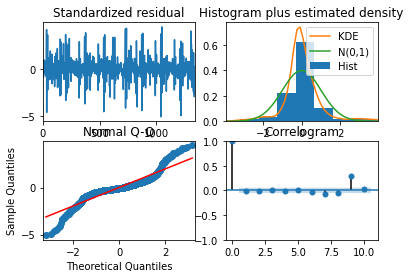

In [ ]:
fig = autoarima_model.plot_diagnostics()

Add a column to the pred dataframe from earlier that forecasts for the future (length of the test set). 

In [ ]:
pred['autoarima'] = autoarima_model.predict(len(bixi_2019_departures_test))

Using the same method as before, add a line of code below to compute the mean squared error of the auto ARIMA model.  __How did the auto ARIMA model perform compared to the baselines? How did the auto ARIMA model compare to the Prophet model from last week? Why do you think the auto ARIMA model performed the way it did?__

In [ ]:
from sklearn.metrics import mean_squared_error
print('Mean baseline MSE: ', mean_squared_error(pred['mean_baseline'], bixi_2019_departures_test['y']))
## Fill in the remaining code here
print('Naive baseline MSE: ', mean_squared_error(pred['naive_baseline'], bixi_2019_departures_test['y']))
print('Naive seasonal baseline MSE : ', mean_squared_error(pred['seasonal_naive_baseline'], bixi_2019_departures_test['y']))
print('Drift baseline MSE: ', mean_squared_error(pred['drift_baseline'], bixi_2019_departures_test['y']))
print('Auto Arima Model :', mean_squared_error(pred['autoarima'], bixi_2019_departures_test['y']))

Mean baseline MSE:  807769.6774526087
Naive baseline MSE:  781261.6568047337
Naive seasonal baseline MSE :  651260.1420118343
Drift baseline MSE:  854448.4962399808
Auto Arima Model : 647405.331983888


Plot the prediction agaist the test data using the following code. 

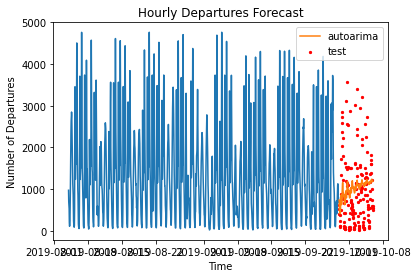

In [ ]:
plt.plot(bixi_2019_departures_train['ds'], bixi_2019_departures_train['y'])
plt.plot(bixi_2019_departures_test['ds'], pred['autoarima'], label = 'autoarima')
plt.scatter(bixi_2019_departures_test['ds'], bixi_2019_departures_test['y'], color = 'red', s = 5, label = 'test')
plt.title('Hourly Departures Forecast')
plt.xlabel('Time')
plt.ylabel('Number of Departures')
plt.legend()
plt.show()

## Forecast using the ARIMA model 

Now we can forecast using the full dataset. First you must fit the model to the full dataset (train + test) and then predict into the future one week. Note that the last line stores information for both the point estimate (forecast) and the confidence intervals. 

In [ ]:
full_autoarima_model = autoarima_model.fit(bixi_2019_departures['y'])
future = 7*24 
forecast, confidence_intervals = full_autoarima_model.predict(n_periods = future, return_conf_int = True)

In [ ]:
final_date = bixi_2019_departures['ds'][len(bixi_2019_departures['ds']) - 1]
future_dates = pd.date_range("2019-11-01 00:00:00", periods = future, freq = 'H')

Use the below code to plot the forecast. We can also plot the confidence interval. __Add code to add a title, xlabel, ylabel, and legend below.__

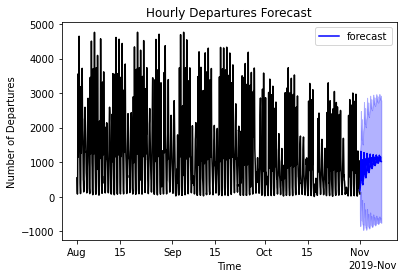

In [ ]:
import matplotlib.dates as mdates
locator = mdates.AutoDateLocator(minticks = 10, maxticks = 15)
formatter = mdates.ConciseDateFormatter(locator)
plt.gca().xaxis.set_major_locator(locator) 
plt.gca().xaxis.set_major_formatter(formatter)

plt.plot(bixi_2019_departures['ds'], bixi_2019_departures['y'], c = 'black')
plt.plot(future_dates, forecast, c = 'blue', label = 'forecast')
plt.fill_between(future_dates, confidence_intervals[:,0], confidence_intervals[:,1], color = 'blue', alpha = 0.3)
## Your code here
plt.title('Hourly Departures Forecast')
plt.xlabel('Time')
plt.ylabel('Number of Departures')
plt.legend()
plt.show()

## More Practice? 

From our analysis, it appears that ARIMA is not the best forecasting method for the Bixi departures data. It was posed as a question earlier, but one possible explanation for this is that, without incorporating more complex methods, we could only allow for one seasonality period. However our data has both weekly and hourly seasonality. 

You can visit this page (https://alkaline-ml.com/pmdarima/modules/classes.html#pmdarima-datasets-toy-timeseries-datasets) to load in some toy time series datasets if you want more practice with auto ARIMA and want to try to replicate these steps. 